<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [ ]:
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import skimage.io
from skimage.transform import resize

from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()
attrs.head()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

Сперва посмотрим на картинки, затем будем их обрабатывать.

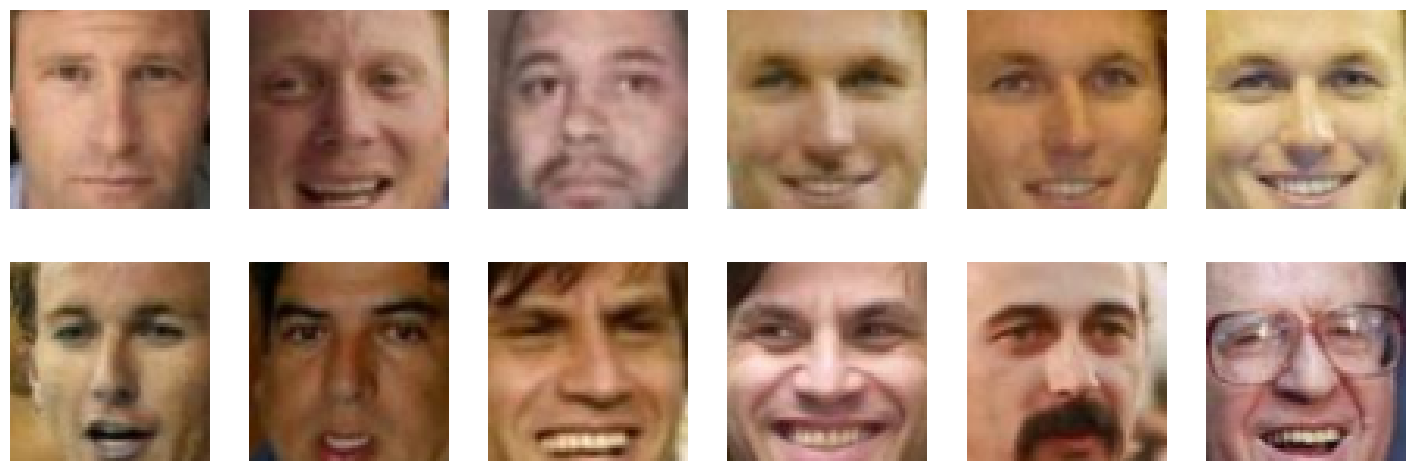

(13143, 64, 64, 3)

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(data[i])
plt.show()
data.shape

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, train_size=0.9, shuffle=False)

train_data_tensor = torch.FloatTensor(train_data).permute(0,3,1,2)
val_data_tensor = torch.FloatTensor(val_data).permute(0,3,1,2)

train_loader = torch.utils.data.DataLoader(train_data_tensor, batch_size=16, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data_tensor, batch_size=16, num_workers=2)

print(next(iter(train_loader)).shape)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([16, 3, 64, 64])


## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучим обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 64 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

Выберу сверточный автоэнкодер без линейных слоев, чтобы сохранить пространственные взаимосвязи.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_features):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 64 -> 32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # 32 -> 16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # 16 -> 8
            nn.BatchNorm2d(64),
            nn.LeakyReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # 8 -> 4
            nn.BatchNorm2d(64),
            nn.LeakyReLU(True),

            # nn.Flatten(),
            # nn.Linear(4*4*64, latent_features)
        )

        # Decoder
        self.decoder = nn.Sequential(
            # nn.Linear(latent_features, 4*4*64),
            # nn.Unflatten(dim=1, unflattened_size=(64, 4, 4)),

            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
       )

    def forward(self, x):
        # encoding
        latent_code = self.encoder(x)    # латентное представление картинки
        # decoding
        reconstruction = self.decoder(latent_code)  # реконструкция изображения
        return reconstruction, latent_code

    def sample(self, sample):
        # sample - латентный вектор
        reconstruction = self.decoder(sample)
        return reconstruction


In [ ]:
criterion = F.mse_loss

autoencoder = Autoencoder(dim_code).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def train(train_loader, val_loader,
          autoencoder, criterion, optimizer, epochs):

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        autoencoder.train()
        avg_train_loss = 0
        for X_batch in train_loader:
            optimizer.zero_grad()
            reconstructed, latent_code = autoencoder(X_batch.to(device))
            loss = criterion(reconstructed, X_batch.to(device))
            loss.backward()
            optimizer.step()
            avg_train_loss += loss / len(train_loader)

        train_losses.append(avg_train_loss.tolist())
        print('train loss: %f' % avg_train_loss)

        autoencoder.eval()
        avg_val_loss = 0

        with torch.no_grad():
            for X_batch in val_loader:
              reconstructed, latent_code = autoencoder(X_batch.to(device))
              loss = criterion(reconstructed, X_batch.to(device))
              avg_val_loss += loss / len(val_loader)

        print('val_loss: %f' % avg_val_loss)
        val_losses.append(avg_val_loss.tolist())

        # Visualize tools
        clear_output(wait=True)
        fig = plt.figure(figsize=(10,4))
        for k in range(3):
            plt.subplot(2, 3, k+1)
            plt.imshow(X_batch[k].permute(1,2,0))
            plt.title('Original')
            plt.axis('off')

            plt.subplot(2, 3, k+4)
            plt.imshow(reconstructed[k].detach().cpu().permute(1,2,0))
            plt.title('Reconstructed')
            plt.axis('off')
        plt.show()

    X_batch.to('cpu')
    del autoencoder
    del X_batch
    torch.cuda.empty_cache()

    return train_losses, val_losses

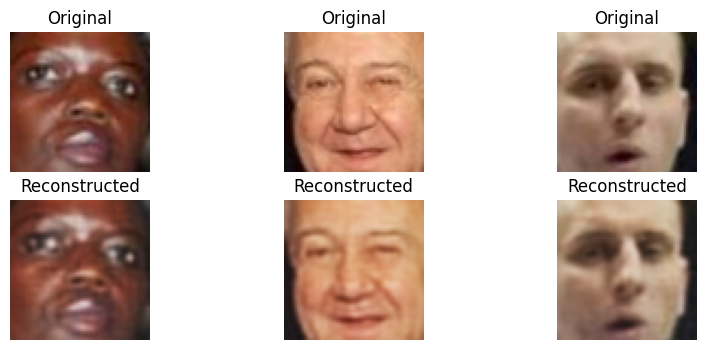

In [ ]:
n_epochs = 20

train_losses, val_losses = train(train_loader, val_loader,
                autoencoder=autoencoder, criterion=criterion, optimizer=optimizer, epochs=n_epochs)

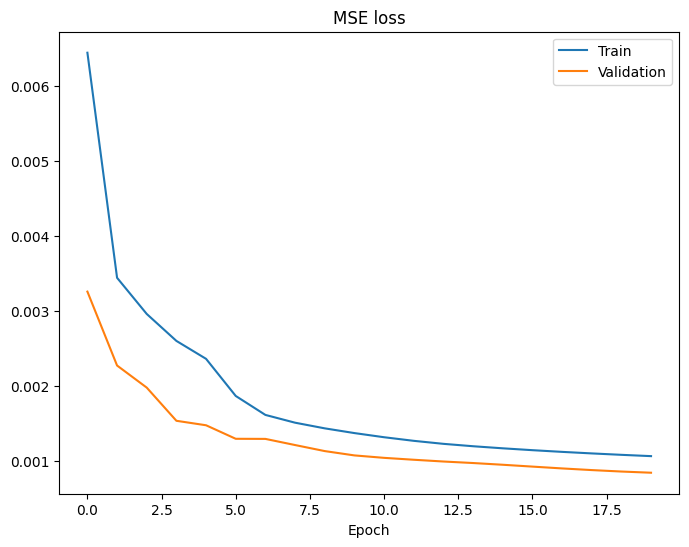

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

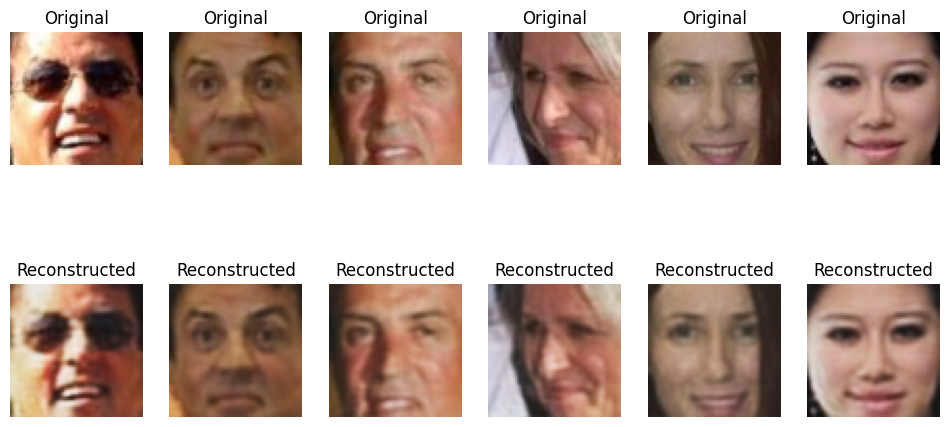

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for batch in val_loader:
      reconstruction, latent_code = autoencoder(batch.to(device))
      break

fig = plt.figure(figsize=(12,6))
for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(batch[k].permute(1,2,0))
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 6, k+7)
    plt.imshow(reconstruction[k].cpu().permute(1,2,0))
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()

del batch
latent_code.to('cpu')
torch.cuda.empty_cache()

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

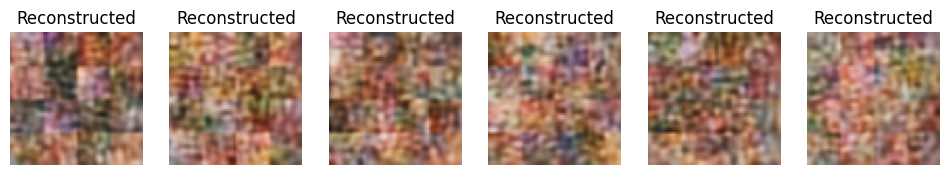

In [ ]:
# Сгенерируем 25 рандомных векторов размера latent_space

z = np.random.randn(25, 64, 4, 4)
output = autoencoder.sample(torch.FloatTensor(z).to(device))

fig = plt.figure(figsize=(12,6))
for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(output[k].detach().cpu().permute(1,2,0))
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()

Латентные векторы реальных изображений, скорее всего,  и так имеют близкое к стандартному распределение, так как энкодер сети использует батч-нормировку. Тем не менее, поработаем в качестве упражнения с латентными векторами и убедимся, что результат сильно не изменится.

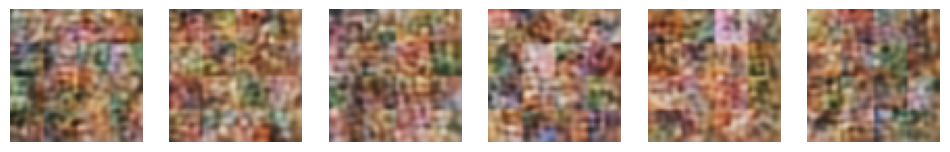

In [ ]:
# Определим параметры распределения латентного вектора
mean = torch.mean(latent_code, dim=(0, 2, 3), keepdim=True)
std = torch.std(latent_code, dim=(0, 2, 3), keepdim=True)
mean = mean.cpu().numpy()
std = std.cpu().numpy()
# print(f'Mean: {mean}\nStandard deviation: {std}')

# Генерируем с вычисленными параметрами
z = np.random.normal(mean, std, (25, 64, 4, 4))
z = torch.FloatTensor(z).to(device)
output = autoencoder.sample(z)

fig = plt.figure(figsize=(12,6))
for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(output[k].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.show()

torch.cuda.empty_cache()

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
# list(attrs)

<Axes: >

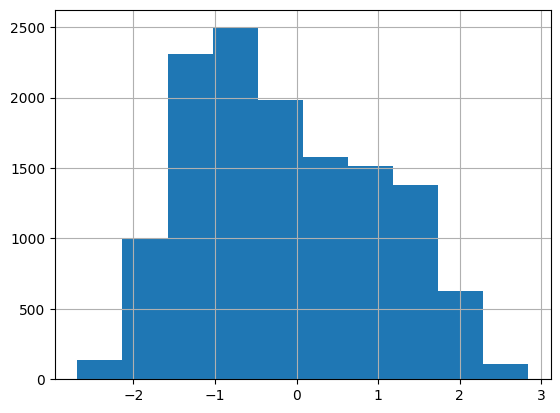

In [ ]:
attrs['Smiling'].hist()

In [ ]:
# Отбор улыбок в датафрейме
smile = attrs[attrs['Smiling'] > 1.9]
no_smile = attrs[attrs['Smiling'] < -1.9]
smile = smile.index.tolist()
no_smile = no_smile.index.tolist()

# Отбор улыбок в изображениях
smiling_data = np.take(data, smile, axis=0)
no_smiling_data = np.take(data, no_smile, axis=0)

# Трансформация в тензоры и даталоадеры
smiling_tensor = torch.FloatTensor(smiling_data).permute(0,3,1,2)
no_smiling_tensor = torch.FloatTensor(no_smiling_data).permute(0,3,1,2)
smile_loader = torch.utils.data.DataLoader(smiling_tensor, batch_size=8)
no_smile_loader = torch.utils.data.DataLoader(no_smiling_tensor, batch_size=8)

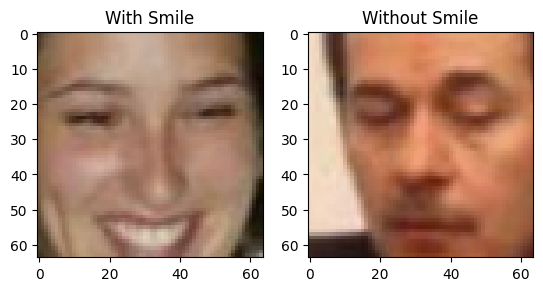

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(smiling_data[0])
plt.title('With Smile')
plt.subplot(1, 2, 2)
plt.imshow(no_smiling_data[0])
plt.title('Without Smile')
plt.show()

In [ ]:
autoencoder.eval()
latent_smile = torch.FloatTensor().to(device)
latent_no_smile = torch.FloatTensor().to(device)

# латентный вектор для улыбающихся
with torch.no_grad():
    for batch in smile_loader:
        _, latent = autoencoder(batch.to(device))
        latent_smile = torch.cat((latent_smile, latent))

# латентный вектор для грустных
with torch.no_grad():
    for batch in no_smile_loader:
        _, latent = autoencoder(batch.to(device))
        latent_no_smile = torch.cat((latent_no_smile, latent))


In [ ]:
smile_array = torch.mean(latent_smile, axis=0) - torch.mean(latent_no_smile, axis=0)
added_smile = latent_no_smile + smile_array

# Подставляем латентный вектор с добавленной улыбкой в decoder
with torch.no_grad():
    output = autoencoder.sample(added_smile)


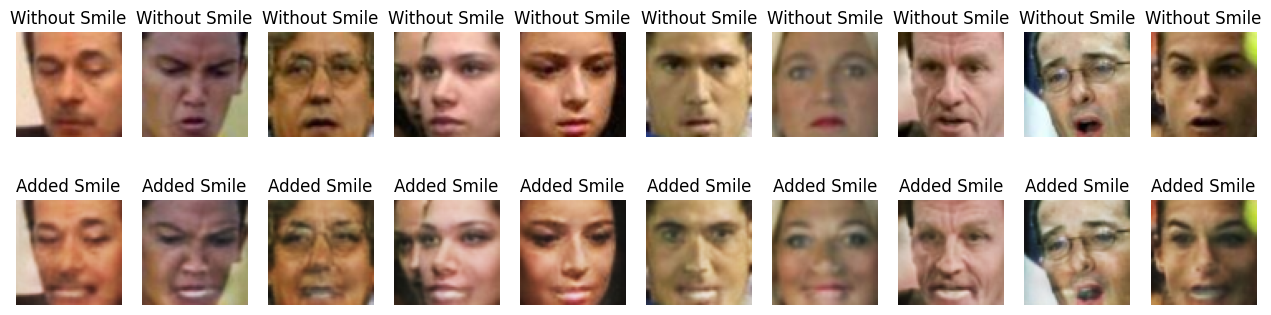

In [ ]:
fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(no_smiling_data[i])
    plt.axis('off')
    plt.title('Without Smile')
    plt.subplot(2, 10, i+11)
    plt.imshow(output[i].cpu().permute(1,2,0))
    plt.axis('off')
    plt.title('Added Smile')

plt.show()

In [ ]:
autoencoder.to("cpu")
del autoencoder
del attrs, data
torch.cuda.empty_cache()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 40188407.42it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1091873.25it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2213863.11it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9306560.22it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
# dim_code = 2 # выберите размер латентного вектора

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.Flatten()
        )

        self.mu = nn.Linear(256*2*2, 4)
        self.logsigma = nn.Linear(256*2*2, 4)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(4, 256*2*2),
            nn.Unflatten(dim=1, unflattened_size=(256, 2, 2)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=2,  output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        return self.mu(x), self.logsigma(x)

    def gaussian_sampler(self, mu, logsigma):
        # латентный вектор из нормального распределения с параметрами mu и sigma
        if self.training:
            # std = exp(1/2 lnD)
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + (eps * std)
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            return mu

    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def latent_vector(self, x):
        mu, logsigma = self.encode(x)
        return self.gaussian_sampler(mu, logsigma)

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return reconstruction, mu, logsigma

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
criterion = loss_vae

autoencoder = VAE()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4)

In [ ]:
epochs = 15
train_losses = []
val_losses = []
autoencoder.to(device)

for epoch in tqdm(range(epochs)):
    print('* Epoch %d/%d' % (epoch+1, epochs))
    autoencoder.train()
    train_losses_per_epoch = []

    for batch, _ in train_loader:
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch.to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    train_losses.append(np.mean(train_losses_per_epoch))
    print('train loss: %f' % train_losses[-1])

    autoencoder.eval()
    val_losses_per_epoch = []

    with torch.no_grad():
        for batch, _ in test_loader:
          reconstruction, mu, logsigma = autoencoder(batch.to(device))
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())
    val_losses.append(np.mean(val_losses_per_epoch))
    print('val_loss: %f' % val_losses[-1])


  0%|          | 0/15 [00:00<?, ?it/s]

* Epoch 1/15
train loss: 5125.378420


  7%|▋         | 1/15 [00:28<06:41, 28.65s/it]

val_loss: 4294.558230
* Epoch 2/15
train loss: 4288.025143


 13%|█▎        | 2/15 [00:48<05:04, 23.42s/it]

val_loss: 4138.461400
* Epoch 3/15
train loss: 4187.443463


 20%|██        | 3/15 [01:08<04:23, 21.92s/it]

val_loss: 4075.318936
* Epoch 4/15
train loss: 4128.574581


 27%|██▋       | 4/15 [01:29<03:55, 21.42s/it]

val_loss: 4068.042738
* Epoch 5/15
train loss: 4090.326622


 33%|███▎      | 5/15 [01:48<03:27, 20.76s/it]

val_loss: 4036.536155
* Epoch 6/15
train loss: 4056.576589


 40%|████      | 6/15 [02:08<03:03, 20.35s/it]

val_loss: 3967.520854
* Epoch 7/15
train loss: 4028.994238


 47%|████▋     | 7/15 [02:27<02:40, 20.02s/it]

val_loss: 3940.530086
* Epoch 8/15
train loss: 4007.955475


 53%|█████▎    | 8/15 [02:47<02:20, 20.05s/it]

val_loss: 3932.929813
* Epoch 9/15
train loss: 3987.417673


 60%|██████    | 9/15 [03:09<02:04, 20.68s/it]

val_loss: 3914.070670
* Epoch 10/15
train loss: 3970.364663


 67%|██████▋   | 10/15 [03:32<01:46, 21.31s/it]

val_loss: 3911.358813
* Epoch 11/15
train loss: 3955.289324


 73%|███████▎  | 11/15 [03:54<01:25, 21.43s/it]

val_loss: 3902.723042
* Epoch 12/15
train loss: 3942.147336


 80%|████████  | 12/15 [04:14<01:02, 20.96s/it]

val_loss: 3867.843187
* Epoch 13/15
train loss: 3930.730373


 87%|████████▋ | 13/15 [04:33<00:41, 20.51s/it]

val_loss: 3888.217195
* Epoch 14/15
train loss: 3919.864341


 93%|█████████▎| 14/15 [04:53<00:20, 20.24s/it]

val_loss: 3884.617519
* Epoch 15/15
train loss: 3910.497514


100%|██████████| 15/15 [05:13<00:00, 20.88s/it]

val_loss: 3871.986443


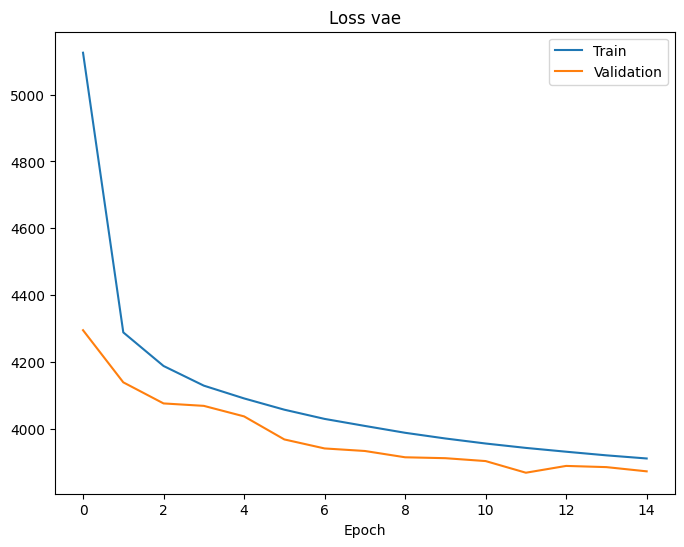

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('Loss vae')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

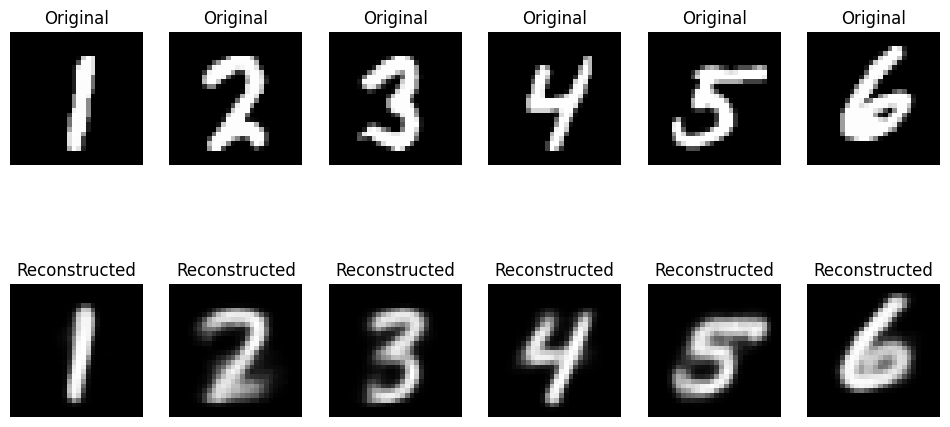

In [ ]:
# Последний батч из test_loader
fig = plt.figure(figsize=(12,6))
for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(batch[k].detach().cpu().squeeze(0), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 6, k+7)
    plt.imshow(reconstruction[k].detach().cpu().squeeze(0), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

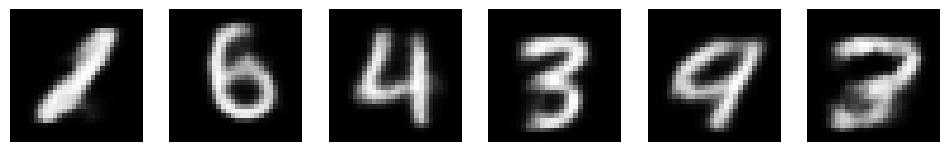

In [ ]:
# Из стандартного распределения (mu=0, std=1)
z = np.array([np.random.normal(0, 1, 4) for i in range(10)])
z = torch.FloatTensor(z)

autoencoder.eval()
with torch.no_grad():
    output = autoencoder.decode(z.to(device))

fig = plt.figure(figsize=(12,6))
for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(output[k].cpu().squeeze(0), cmap='gray')
    plt.axis('off')
plt.show()

Mean: 0.0319722966957609
Standard deviation: 1.0262140245326787


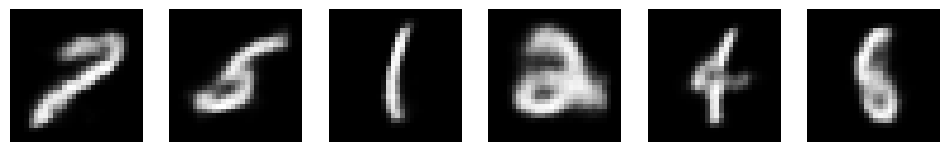

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных

autoencoder.eval()
lat_mean, lat_std = [], []
with torch.no_grad():
    for batch, _ in test_loader:
        reconstruction, mu, log_var = autoencoder(batch.to(device))
        lat_mean.append(np.mean(mu.cpu().squeeze().tolist()))
        lat_std.append(np.std(log_var.cpu().squeeze().tolist()))

mu = np.mean(lat_mean)
log_var = np.std(lat_std)
std = np.exp(0.5 * log_var)
print(f'Mean: {mu}\nStandard deviation: {std}')

z = np.array([np.random.normal(mu, std, 4) for i in range(10)])
z = torch.FloatTensor(z)

with torch.no_grad():
    output = autoencoder.decode(z.to(device))

fig = plt.figure(figsize=(12,6))
for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(output[k].cpu().squeeze(0), cmap='gray')
    plt.axis('off')
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
latent = torch.FloatTensor()
for batch in test_loader:
    img = batch[0]
    autoencoder.eval()
    with torch.no_grad():
        lat = autoencoder.latent_vector(img.to(device))
    latent = torch.cat((latent, lat.cpu()))
labels = [batch[1] for batch in test_dataset]

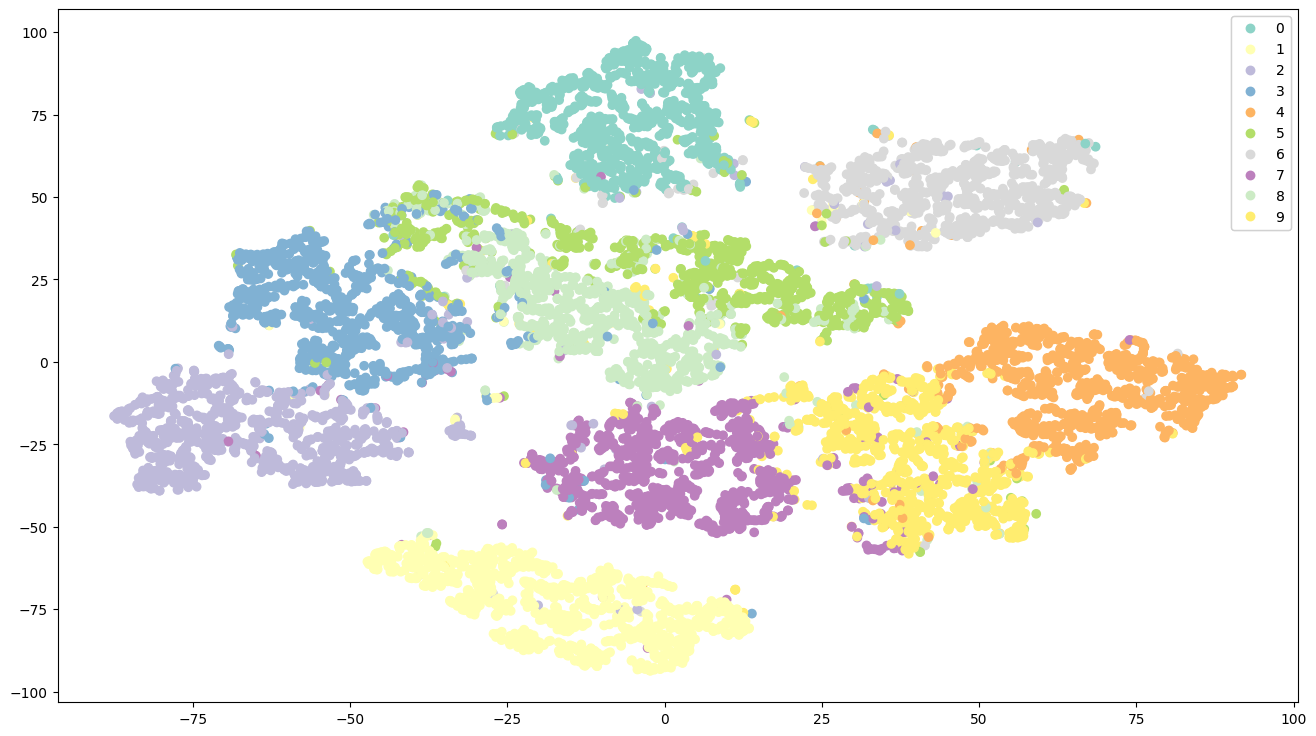

In [ ]:
from sklearn.manifold import TSNE
latent_tsne = TSNE(2).fit_transform(latent)

fig, ax = plt.subplots(figsize=(16,9))
scatter = ax.scatter(x=latent_tsne[:, 0], y=latent_tsne[:, 1], c=labels, cmap='Set3')
legend = ax.legend(*scatter.legend_elements(), loc="upper right")
ax.add_artist(legend)
plt.show()

Что вы думаете о виде латентного представления?  
Латентное представление цифр выглядит довольно компактным. Цифры в нем между собой визуально различимы. Можно отметить, что у "5" более вытянутое распределение, которое отчасти пересекается с распределениями "3" и "8". Накладывание наблюдается также и у других похожих пар цифр: "7" и "9", "9" и "4". В то же время зазоры между кластерами хоть и разделяют различные числа, но при попадании в них sample случайного латентного вектора генерируются непонятные числа, как было видно из предыдущего задания.

__Congrats v2.0!__

In [ ]:
del autoencoder
del batch, _
torch.cuda.empty_cache()

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1+10, 32, kernel_size=3, stride=2, padding=1),   # 28 -> 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),    # 14 -> 7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),   # 7 -> 4
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 4 -> 2
            nn.Flatten()
        )

        self.mu = nn.Linear(256*2*2, 4)
        self.logsigma = nn.Linear(256*2*2, 4)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(4+10, 256*2*2),
            nn.Unflatten(dim=1, unflattened_size=(256, 2, 2)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=2,  output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        # one-hot кодирование метки
        y = F.one_hot(class_num, num_classes=10)
        y = y.type_as(torch.FloatTensor()).to(device)
        # расширение размерности
        y = y.unsqueeze(-1).unsqueeze(-1)
        y = y.expand(x.size(0), -1, x.size(2), x.size(3))
        # concatenate x and y along channel dimension (1+10)
        x = torch.cat([x, y], dim=1)

        x = self.encoder(x)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        # если model.train()
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + (eps * std)
        # если model.eval()
        else:
            return mu

    def latent_vector(self, x, class_num):
        mu, logsigma = self.encode(x, class_num)
        return self.gaussian_sampler(mu, logsigma)

    def decode(self, z, class_num):
        y = F.one_hot(class_num, num_classes=10)
        y = y.type_as(torch.FloatTensor()).to(device)
        z = torch.cat([z, y], dim=1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return reconstruction, mu, logsigma

In [ ]:
criterion = loss_vae

autoencoder = CVAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4)

In [ ]:
epochs = 15
train_losses = []
val_losses = []

for epoch in tqdm(range(epochs)):
    print('* Epoch %d/%d' % (epoch+1, epochs))
    autoencoder.train()
    train_losses_per_epoch = []

    for batch, class_num in train_loader:
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch.to(device), class_num.to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    train_losses.append(np.mean(train_losses_per_epoch))
    print('train loss: %f' % train_losses[-1])

    autoencoder.eval()
    val_losses_per_epoch = []

    with torch.no_grad():
        for batch, class_num in test_loader:
          reconstruction, mu, logsigma = autoencoder(batch.to(device), class_num.to(device))
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())
    val_losses.append(np.mean(val_losses_per_epoch))
    print('val_loss: %f' % val_losses[-1])

  0%|          | 0/15 [00:00<?, ?it/s]

* Epoch 1/15
train loss: 4812.143118


  7%|▋         | 1/15 [00:25<06:01, 25.79s/it]

val_loss: 3851.890489
* Epoch 2/15
train loss: 3883.755446


 13%|█▎        | 2/15 [00:47<05:04, 23.41s/it]

val_loss: 3734.647087
* Epoch 3/15
train loss: 3788.124999


 20%|██        | 3/15 [01:10<04:38, 23.19s/it]

val_loss: 3685.724802
* Epoch 4/15
train loss: 3741.858053


 27%|██▋       | 4/15 [01:32<04:12, 22.92s/it]

val_loss: 3623.536745
* Epoch 5/15
train loss: 3708.089579


 33%|███▎      | 5/15 [01:55<03:46, 22.69s/it]

val_loss: 3606.371028
* Epoch 6/15
train loss: 3682.411338


 40%|████      | 6/15 [02:18<03:24, 22.74s/it]

val_loss: 3577.553884
* Epoch 7/15
train loss: 3662.379804


 47%|████▋     | 7/15 [02:39<02:58, 22.28s/it]

val_loss: 3575.494342
* Epoch 8/15
train loss: 3646.221580


 53%|█████▎    | 8/15 [03:01<02:35, 22.21s/it]

val_loss: 3557.924099
* Epoch 9/15
train loss: 3632.209284


 60%|██████    | 9/15 [03:23<02:13, 22.24s/it]

val_loss: 3553.145744
* Epoch 10/15
train loss: 3621.335297


 67%|██████▋   | 10/15 [03:46<01:51, 22.35s/it]

val_loss: 3543.193199
* Epoch 11/15
train loss: 3611.269711


 73%|███████▎  | 11/15 [04:08<01:29, 22.37s/it]

val_loss: 3539.851381
* Epoch 12/15
train loss: 3602.018761


 80%|████████  | 12/15 [04:30<01:06, 22.15s/it]

val_loss: 3537.253289
* Epoch 13/15
train loss: 3592.598641


 87%|████████▋ | 13/15 [04:52<00:44, 22.16s/it]

val_loss: 3520.960046
* Epoch 14/15
train loss: 3587.660067


 93%|█████████▎| 14/15 [05:15<00:22, 22.36s/it]

val_loss: 3518.748745
* Epoch 15/15
train loss: 3580.756146


100%|██████████| 15/15 [05:37<00:00, 22.49s/it]

val_loss: 3530.292846


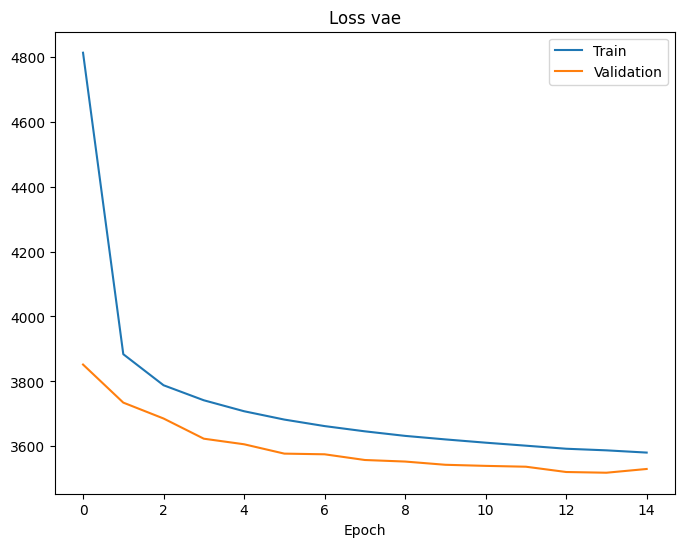

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('Loss vae')
plt.legend()
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

Mean: -0.019406043132939102
Standard deviation: 1.0222480699653682


<ipython-input-8-ac8815dfc3c1>:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 10, i+1)


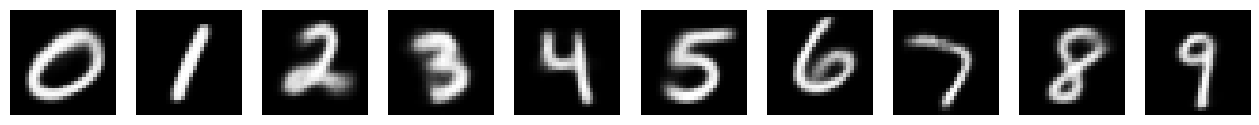

In [ ]:
autoencoder.eval()
lat_mean, lat_std = [], []
with torch.no_grad():
    for batch, class_num in test_loader:
        mu, log_var = autoencoder.encode(batch.to(device), class_num.to(device))
        lat_mean.append(np.mean(mu.cpu().squeeze().tolist()))
        lat_std.append(np.std(log_var.cpu().squeeze().tolist()))

mu = np.mean(lat_mean)
log_var = np.std(lat_std)
std = np.exp(0.5 * log_var)
print(f'Mean: {mu}\nStandard deviation: {std}')

z = np.array([np.random.normal(mu, std, 4) for i in range(10)])
z = torch.FloatTensor(z)
class_num = torch.tensor(list(range(10)))
with torch.no_grad():
    output = autoencoder.decode(z.to(device), class_num.to(device))

fig, ax = plt.subplots(1, 10, figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(output[i].cpu().squeeze(0), cmap = 'gray')
    plt.axis('off')
plt.show()

torch.cuda.empty_cache()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

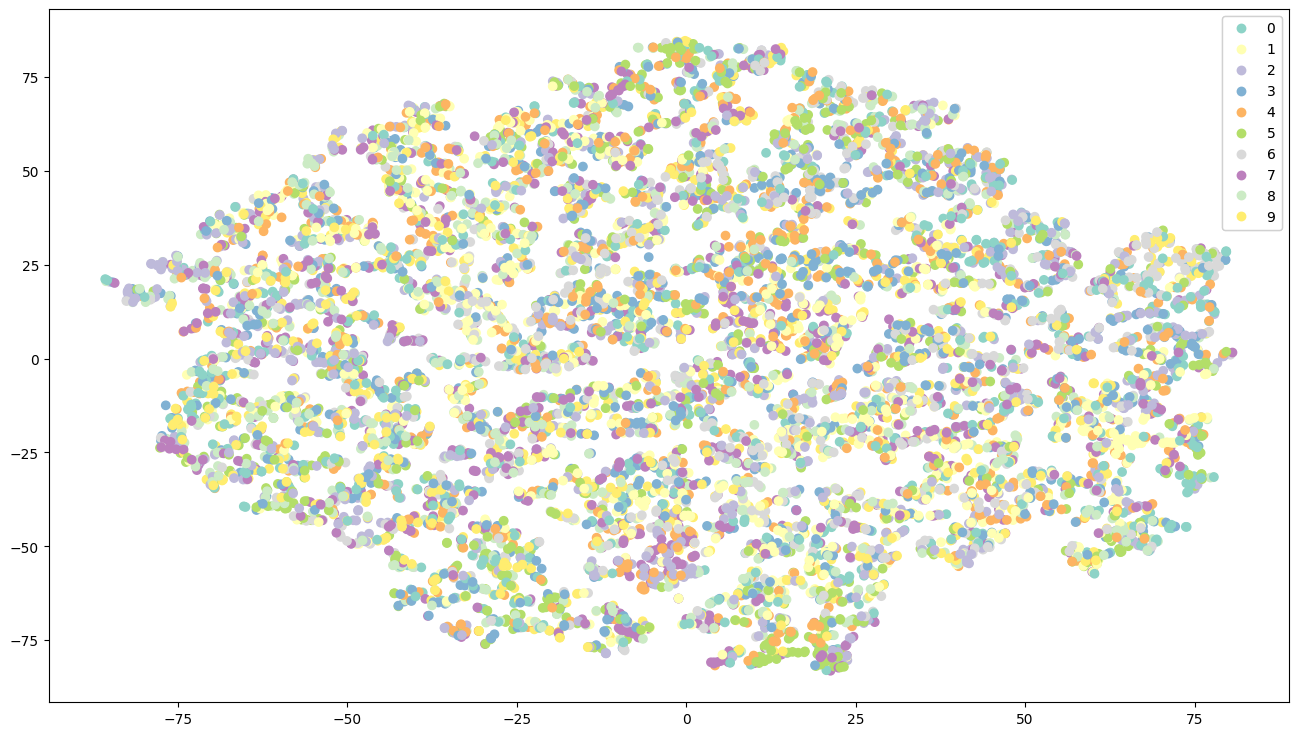

In [ ]:
labels = [batch[1] for batch in test_dataset]
latent = torch.FloatTensor()
for img, class_num in test_loader:
    autoencoder.eval()
    with torch.no_grad():
        lat = autoencoder.latent_vector(img.to(device), class_num.to(device))
    latent = torch.cat((latent, lat.cpu()))

from sklearn.manifold import TSNE
latent_tsne = TSNE(2).fit_transform(latent)

fig, ax = plt.subplots(figsize=(16,9))
scatter = ax.scatter(x=latent_tsne[:, 0], y=latent_tsne[:, 1], c=labels, cmap='Set3')
legend = ax.legend(*scatter.legend_elements(), loc="upper right")
ax.add_artist(legend)
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

В отличие от VAE в случае с CVAE классы перемешаны, и нет четкого обособления кластеров. Следовательно, модель CVAE сама понимает какому классу будет принадлежать сгенерированный латентный вектор, даже не имея четких границ между кластерами.  
В случае с другими датасетами (не mnist) это может быть полезно для генерации совершенно новых изображений, являющихся промежуточными для обучающей выборки.